# <center>Lab of 2nd Exercise</center>

## <center> Speech Recognition using HMMs and RNNs </center>

#### The first 8 steps were implemented as a part of the PrepareLab located in prepare_lab folder.

### Description

Our goal is the implementation of a speech recognition system, that recognizes isolated words. The first part involves the extraction of the appropriate acoustic features from our recordings and their further analysis. These features are the cepstral coefficients, that are computed using a filterbank (inspired by psychoacoustic methods).

More specifically, the system will recognize isolated digits in English. Our dataset contains dictations of 9 digits from 15 different speakers in separate .wav files. In total, there are 133 files, since 2 dictations are missing. The name of each file (e.g. eight8.wav) declares both the dictated digit (e.g. eight) and the speaker (speakers are numbered from 1 to 15). The sampling rate is Fs=16k and the duration of each dictation differs.

### Implementation

Import necessary libraries

In [1]:
import librosa as l
import os
import re
import IPython.display as ipd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# pytorch
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

# pandas
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

__Step 1:__ Sound analysis using [Praat](http://www.fon.hum.uva.nl/praat/). 

- Open __onetwothree1.wav__ and __onetwothree8.wav__ using Praat. These files contain the phrase "one two three" from speakers 1 and 8 (male and female respectively).

- Waveforms of male and female speaker


<img src="prepare_lab/outputs/waveform.png" alt="Waveforms" style="width: 700px;height: 700px;"/>


- Spectogram of male speaker

<img src="prepare_lab/outputs/spec_male.png" alt="Male specrogram" style="width: 700px; height: 700px;"/>

Spectogram of female speaker

<img src="prepare_lab/outputs/spec_female.png" alt="Female specrogram" style="width: 700px;height: 700px; "/>

- Extract the mean value of the pitch for the vowels "α" "ου" and "ι" (in praat select the part of the waveform that the vowel exists and press "F5").

| File | Gender | Vowel | Pitch (Hz) |
| -----| -----  | ----- | ----- |
| onetwothree1.wav | male | α | 133.66 |
| onetwothree1.wav | male | ου | 128.51 |
| onetwothree1.wav | male | ι | 130.3 |
| onetwothree8.wav | female | α | 176.83 |
| onetwothree8.wav | female | ου | 179.81 |
| onetwothree8.wav | female | ι | 174.59 |

We observe that the pitch of the female speaker is higher than the pitch of the male speaker in all vowels. As a result, we can use pitch in order to distinguish the gender of the speaker. However, we can't use pitch in a digit recognition task, since for a single speaker the pitch of different vowels is close to each other.

- Extract the first 3 formants for each vowel (in praat select the central point in the part of the waveform that the vowel exists and press F1, F2 and F3 respectively).

| File | Gender | Vowel | F1 | F2 | F3 |
| -----| -----  | ----- | -- | -- | -- |
| onetwothree1.wav | male | α | 782 | 1069 | 2243 |
| onetwothree8.wav | female | α | 951 | 1584 | 2999 |
| onetwothree1.wav | male | ου | 359 | 1818 | 2443 |
| onetwothree8.wav | female | ου | 370 | 2150 | 2663 |
| onetwothree1.wav | male | ι | 386 | 1981 | 2447 |
| onetwothree8.wav | female | ι | 356 | 2456 | 2552 |

We observe that the formants differ from each other in different vowels and are not influenced a lot when the speaker is changed. So, these peaks (F1, F2, F3) can be used in speech recognition to distinguish vowels.

__Step 2:__ Create a function (data parser) that reads the sound files in __digits/__ folder and returns 3 Python lists: the .wav file read in librosa, the respective speaker and the digit.

In [3]:
# Define useful variables
n_samples = 133
digits_dir = "./pr_lab2_2019-20_data/digits"
sr = 16000
# Dictionary to convert string digits in their numerical format.
str2num = {'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6,
          'seven':7, 'eight':8, 'nine':9}
# Dictionary to convert digits from numerical format in their
# string representation.
num2str = {v: k for k, v in str2num.items()}

In [4]:
# Simple parser that split a string in the first digit
def digit_split(s):
    return re.split(r'(\d+)', s)[:2]

print(digit_split("six13.wav"))

['six', '13']


In [5]:
# Main data parser method
def data_parser(digits_dir):
    wav = [None] * n_samples
    speaker = np.zeros(n_samples, dtype=int)
    digit = np.zeros(n_samples, dtype=int)
    
    for i, file in enumerate(os.listdir(digits_dir)):
        filename = os.fsdecode(file)
        # Read wav file with librosa
        wav[i],_ = l.load(os.path.join(digits_dir, filename), sr=16000)
        # Keep speaker and digit
        decoded_name = digit_split(filename.split('.')[0])
        if decoded_name[0] in str2num:
            digit[i] = str2num[decoded_name[0]]
        else:
            print("Error in decoding " + str(decoded_name[0]))
        speaker[i] = int(decoded_name[1])
    return wav, speaker, digit
        

In [6]:
wav, speaker, digit = data_parser(digits_dir)

Check data parser before continue on step 3.

In [7]:
# Print first three files
for i in range(3):
    print("Sample " + str(i))
    print("Waveform: " + str(wav[i][:3]))
    print("Speaker: " + str(speaker[i]))
    print("Digit: " + str(digit[i]))
    print()

Sample 0
Waveform: [-0.00048828 -0.00015259  0.00030518]
Speaker: 5
Digit: 5

Sample 1
Waveform: [0.         0.00015259 0.00021362]
Speaker: 11
Digit: 9

Sample 2
Waveform: [-0.00073242 -0.00088501 -0.00085449]
Speaker: 8
Digit: 2



In [8]:
# Sample a random file
sample = random.randint(0,n_samples-1)
# Construct its correct filename
name = num2str[digit[sample]] + str(speaker[sample]) + '.wav'
print(name)
# Play it and check that parser is correct.
ipd.Audio("./pr_lab2_2019-20_data/digits/" + name)

eight2.wav


__Step 3:__ Extract Mel-Frequency Cepstral Coefficients (MFCCs) from each sound file using librosa (13 features per file). Use 25 ms window size and 10 ms step size. Also, compute delta and delta-deltas of the features.

In [9]:
# Convert window and step size from ms to number os points.
n_fft = int(sr * 0.025)  
hop_length = int(sr * 0.01)

mfccs = []
delta = []
delta_deltas = []
# For each sample compute the mfccs, the deltas and the delta-deltas. 
for i in range(n_samples):
    mfcc = l.feature.mfcc(wav[i], sr=sr, n_mfcc=13, hop_length=hop_length, n_fft=n_fft)
    mfccs.append(mfcc)
    delta.append(l.feature.delta(mfcc))
    delta_deltas.append(l.feature.delta(mfcc, order=2))

__Step 4:__ Display a histogram for the 1st and the 2nd MFCC of digits n1 and n2 for all recordings. In my case, n1 = 0 and n2 = 9. Since n1 = 0, we define n1 = 9-1 = 8.

In [10]:
# Extract 1st and 2nd mfcc of digit 8
mfcc1_d8 = [mfccs[i][0] for i in range(n_samples) if digit[i] == 8]
mfcc2_d8 = [mfccs[i][1] for i in range(n_samples) if digit[i] == 8]

# Extract 1st and 2nd mfcc of digit 9
mfcc1_d9 = [mfccs[i][0] for i in range(n_samples) if digit[i] == 9]
mfcc2_d9 = [mfccs[i][1] for i in range(n_samples) if digit[i] == 9]

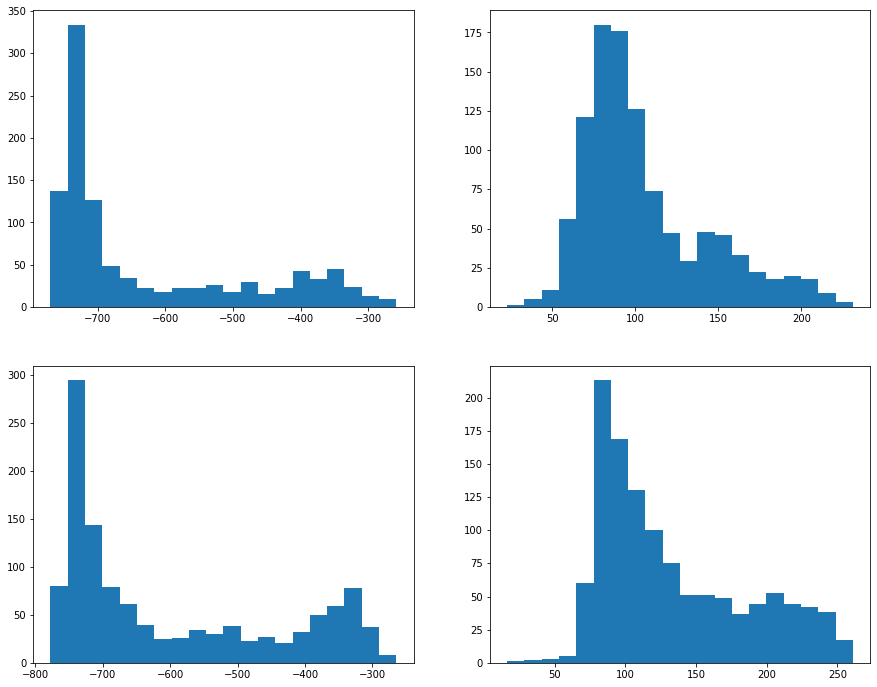

In [11]:
# Define a function that convert a list of lists in a global list
def flat_list(l):
    return [item for sublist in l for item in sublist]

# Flattening
mfcc1_d8_flat = flat_list(mfcc1_d8)
mfcc2_d8_flat = flat_list(mfcc2_d8)
mfcc1_d9_flat = flat_list(mfcc1_d9)
mfcc2_d9_flat = flat_list(mfcc2_d9)

# Plot the histograms
fig = plt.figure(figsize=(15,12))
fig.add_subplot(2, 2, 1)
plt.hist(mfcc1_d8_flat, bins=20)
fig.add_subplot(2, 2, 2)
plt.hist(mfcc2_d8_flat, bins=20)
fig.add_subplot(2, 2, 3)
plt.hist(mfcc1_d9_flat, bins=20)
fig.add_subplot(2, 2, 4)
plt.hist(mfcc2_d9_flat, bins=20)
plt.show()

The divergence between 8 and 9 is small in both featured. In order to classify them, we need more MFCC features.

Choose two recordings for each digit from two different speaker and compute Mel Filterbank Spectral Coefficients (MFSCs). Then, plot the correlation of the MFSCs and MFCCs for each recording.

In [12]:
spk1 = 1
spk2 = 2
n1 = 8
n2 = 9
for i in range(n_samples):
    if speaker[i] == spk1 and digit[i] == n1:
        s1_n1 = i
    if speaker[i] == spk1 and digit[i] == n2:
        s1_n2 = i
    if speaker[i] == spk2 and digit[i] == n1:
        s2_n1 = i
    if speaker[i] == spk2 and digit[i] == n2:
        s2_n2 = i
print("Speaker 1 - Digit 8: " + str(s1_n1))
print("Speaker 1 - Digit 9: " + str(s1_n2))
print("Speaker 2 - Digit 8: " + str(s2_n1))
print("Speaker 2 - Digit 9: " + str(s2_n2))

Speaker 1 - Digit 8: 12
Speaker 1 - Digit 9: 37
Speaker 2 - Digit 8: 109
Speaker 2 - Digit 9: 8


In [13]:
mfscs_1_1 = l.feature.melspectrogram(wav[s1_n1], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfscs_1_2 = l.feature.melspectrogram(wav[s1_n2], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfscs_2_1 = l.feature.melspectrogram(wav[s2_n1], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfscs_2_2 = l.feature.melspectrogram(wav[s2_n2], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)

In order to construct the correlation plot easily, we convert out data in a dataframe and use the function df.corr by pandas.

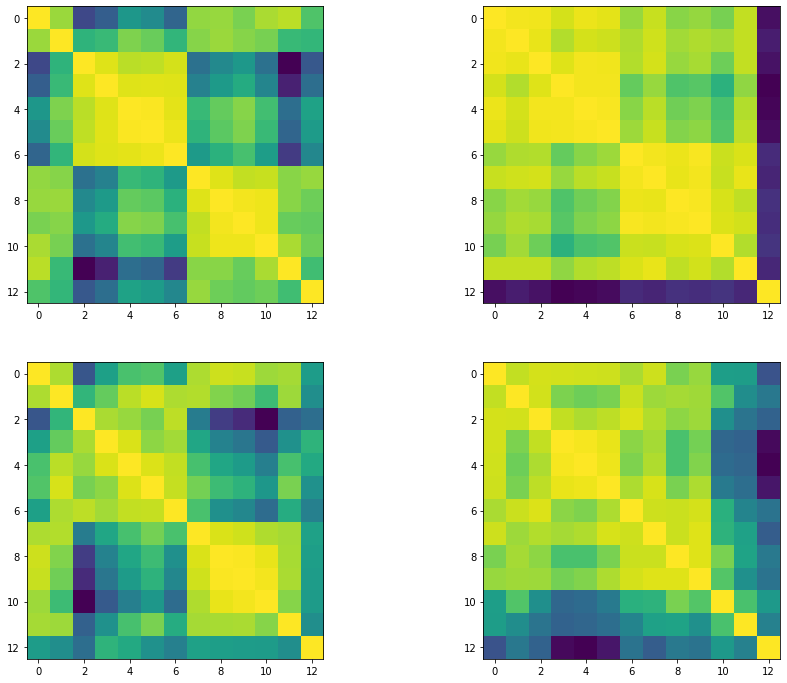

In [14]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2, 2, 1)
mfsc_df_1_1 = pd.DataFrame.from_records(mfscs_1_1.T)
plt.imshow(mfsc_df_1_1.corr())

fig.add_subplot(2, 2, 2)
mfsc_df_1_2 = pd.DataFrame.from_records(mfscs_1_2.T)
plt.imshow(mfsc_df_1_2.corr())

fig.add_subplot(2, 2, 3)
mfsc_df_2_1 = pd.DataFrame.from_records(mfscs_2_1.T)
plt.imshow(mfsc_df_2_1.corr())


fig.add_subplot(2, 2, 4)
mfsc_df_2_2 = pd.DataFrame.from_records(mfscs_2_2.T)
plt.imshow(mfsc_df_2_2.corr())

plt.show()


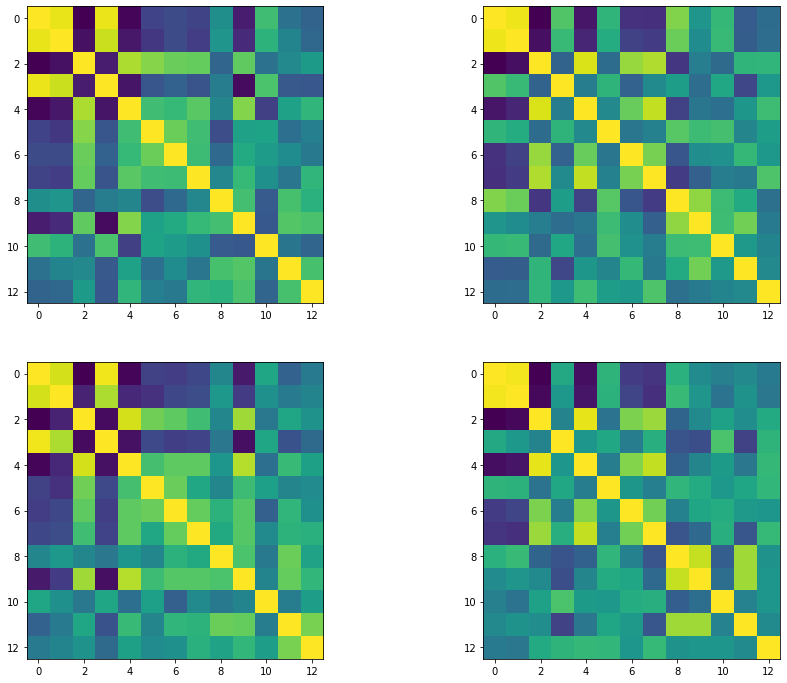

In [15]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2, 2, 1)
mfcc_df_1_1 = pd.DataFrame.from_records(mfccs[s1_n1].T)
plt.imshow(mfcc_df_1_1.corr())

fig.add_subplot(2, 2, 2)
mfcc_df_1_2 = pd.DataFrame.from_records(mfccs[s1_n2].T)
plt.imshow(mfcc_df_1_2.corr())

fig.add_subplot(2, 2, 3)
mfcc_df_2_1 = pd.DataFrame.from_records(mfccs[s2_n1].T)
plt.imshow(mfcc_df_2_1.corr())

fig.add_subplot(2, 2, 4)
mfcc_df_2_2 = pd.DataFrame.from_records(mfccs[s2_n2].T)
plt.imshow(mfcc_df_2_2.corr())

plt.show()

We observe that MFSCs coefficients are higly correlated, while MSCCs are not. This explains the fact that the Discrete Cosine Transform (DCT) is used to decorrelate the mel filter bank coefficients, a process also referred to as whitening.

__Step 5:__ Extraction of a global feature vector for each recording, by combining the mean value and the variance of the mfccs – deltas – delta-deltas for all the windows.

In [16]:
# X = mean mffc  - mean delta - mean delta-deltas- var mfcc - var delta - var delta-deltas 
X = np.zeros((n_samples, 78))

for i in range(n_samples):
    X[i, :13] = np.mean(mfccs[i], axis=1)
    X[i, 13:26] = np.mean(delta[i], axis=1)
    X[i, 26:39] = np.mean(delta_deltas[i], axis=1)
    X[i, 39:52] = np.std(mfccs[i], axis=1)
    X[i, 52:65] = np.std(delta[i], axis=1)
    X[i, 65:] = np.std(delta_deltas[i], axis=1)


Plot the first two dimensions in a 2D scatter plot.

In [17]:
# Define a function that plots the decision surface of 2D-dimensional data
def scatter_2d(X, y, labels):
    fig, ax = plt.subplots()
    # title for the plots
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    
    one = ax.scatter(
        X0[y == 1], X1[y == 1],
        c='red', label=labels[0], 
        s=50, alpha=0.9, edgecolors='k')
    
    two = ax.scatter(
        X0[y == 2], X1[y == 2],
        c='purple', label=labels[1], 
        s=50, alpha=0.9, edgecolors='k')
    
    three = ax.scatter(
        X0[y == 3], X1[y == 3],
        c='green', label=labels[2],
        s=50, alpha=0.9, edgecolors='k')
    
    four = ax.scatter(
        X0[y == 4], X1[y == 4],
        c='gray', label=labels[3], 
        s=50, alpha=0.9, edgecolors='k')
    
    five = ax.scatter(
        X0[y == 5], X1[y == 5],
        c='orange', label=labels[4], 
        s=50, alpha=0.9, edgecolors='k')
    
    six = ax.scatter(
        X0[y == 6], X1[y == 6],
        c='black', label=labels[5],
        s=50, alpha=0.9, edgecolors='k')
    
    seven = ax.scatter(
        X0[y == 7], X1[y == 7],
        c='pink', label=labels[6], 
        s=50, alpha=0.9, edgecolors='k')
    
    eight = ax.scatter(
        X0[y == 8], X1[y == 8],
        c='white', label=labels[7], 
        s=50, alpha=0.9, edgecolors='k')
    
    nine = ax.scatter(
        X0[y == 9], X1[y == 9],
        c='yellow', label=labels[8],
        s=50, alpha=0.9, edgecolors='k')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

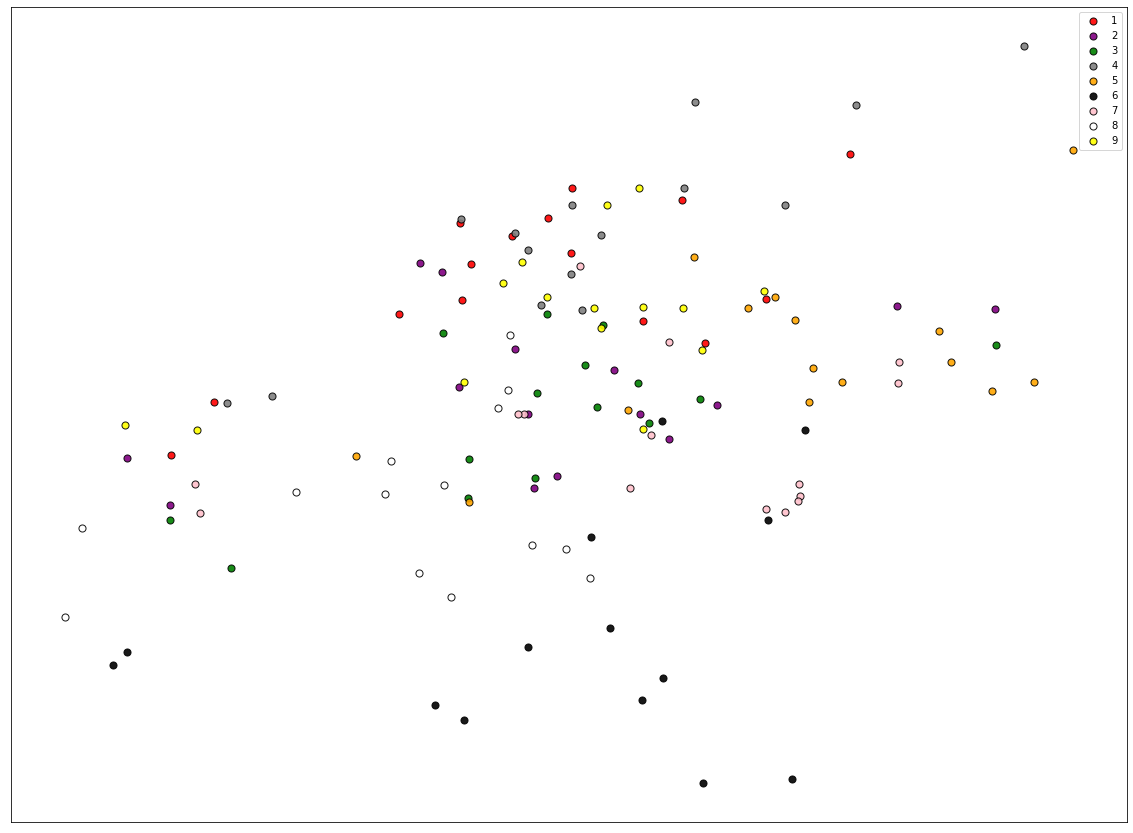

In [18]:
plt.rcParams['figure.figsize'] = [20, 15]
scatter_2d(X, digit, [i for i in range(1,10)])

We observe that if we take into account only the first two dimensions of the global feature vector, the points of the same class are not always close to each other and their class is easily separable among the other classes. As a result, a classifier would perform poorly in these 2D data.

__Step 6:__ Apply PCA to reduce the dimensions of the feature vector from 78 to 2 or 3 and plot the data in 2D and 3D respectively.

In [19]:
# Define PCA
pca_2d = PCA(n_components=2)
# Apply PCA on data
X_2d = pca_2d.fit_transform(X)

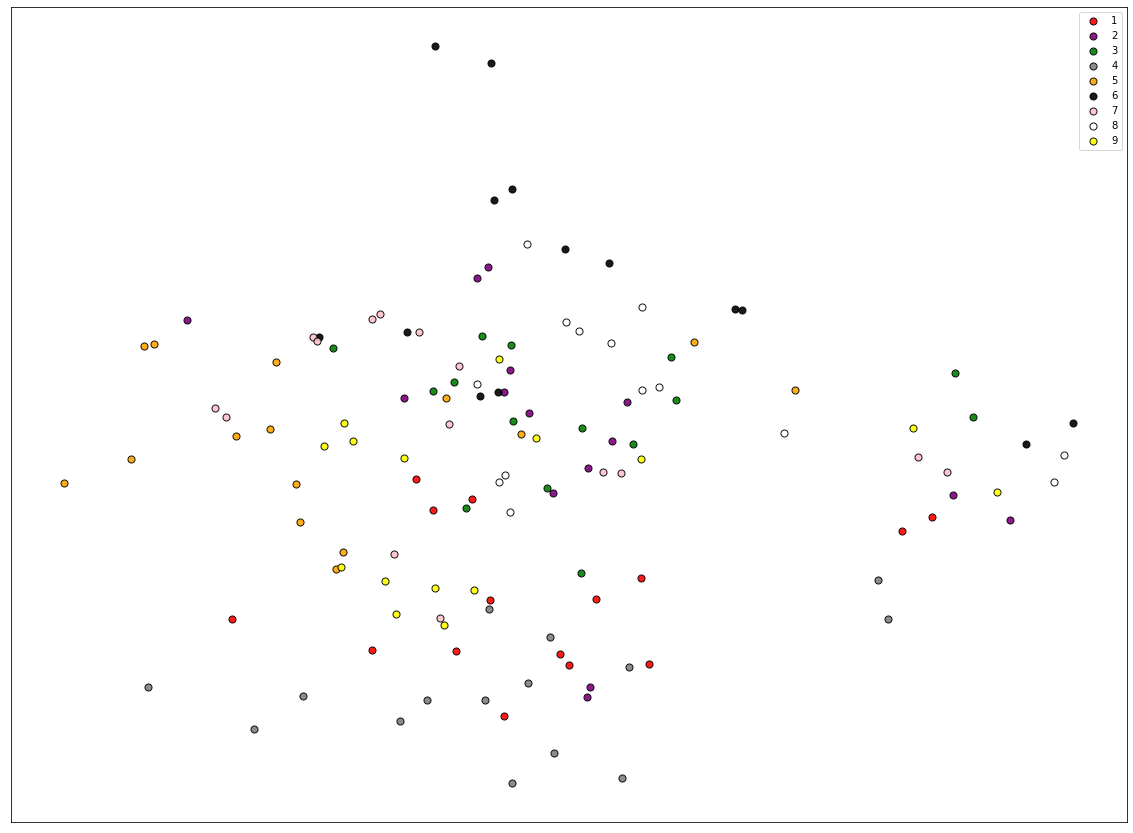

In [20]:
scatter_2d(X_2d, digit, [i for i in range(1, 10)])

After applying PCA, the scatter plot is much better since we kept more information from all the 78 dimensions in our 2D data.

In [21]:
# Define a function that plots the decision surface of 3-dimensional data
def scatter_3d(X, y, labels):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(111, projection='3d')
    # title for the plots
    # Set-up grid for plotting.
    X0, X1, X2 = X[:, 0], X[:, 1], X[:,2]
    
    one = ax.scatter(
        X0[y == 1], X1[y == 1], X2[y == 1],
        c='red', label=labels[0],
        s=50, alpha=0.9, edgecolors='k')

    two = ax.scatter(
        X0[y == 2], X1[y == 2], X2[y == 2],
        c='purple', label=labels[1], 
        s=50, alpha=0.9, edgecolors='k')
    
    three = ax.scatter(
        X0[y == 3], X1[y == 3], X2[y == 3],
        c='green', label=labels[2],
        s=50, alpha=0.9, edgecolors='k')
    
    four = ax.scatter(
        X0[y == 4], X1[y == 4], X2[y == 4],
        c='gray', label=labels[3], 
        s=50, alpha=0.9, edgecolors='k')
    
    five = ax.scatter(
        X0[y == 5], X1[y == 5], X2[y == 5],
        c='orange', label=labels[4], 
        s=50, alpha=0.9, edgecolors='k')
    
    six = ax.scatter(
        X0[y == 6], X1[y == 6], X2[y == 6],
        c='black', label=labels[5],
        s=50, alpha=0.9, edgecolors='k')
    
    seven = ax.scatter(
        X0[y == 7], X1[y == 7], X2[y == 7],
        c='pink', label=labels[6], 
        s=50, alpha=0.9, edgecolors='k')
    
    eight = ax.scatter(
        X0[y == 8], X1[y == 8], X2[y == 8],
        c='white', label=labels[7], 
        s=50, alpha=0.9, edgecolors='k')
    
    nine = ax.scatter(
        X0[y == 9], X1[y == 9], X2[y == 9],
        c='yellow', label=labels[8],
        s=50, alpha=0.9, edgecolors='k')
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

In [22]:
# Define PCA
pca_3d = PCA(n_components=3)
# Apply PCA on data
X_3d = pca_3d.fit_transform(X)

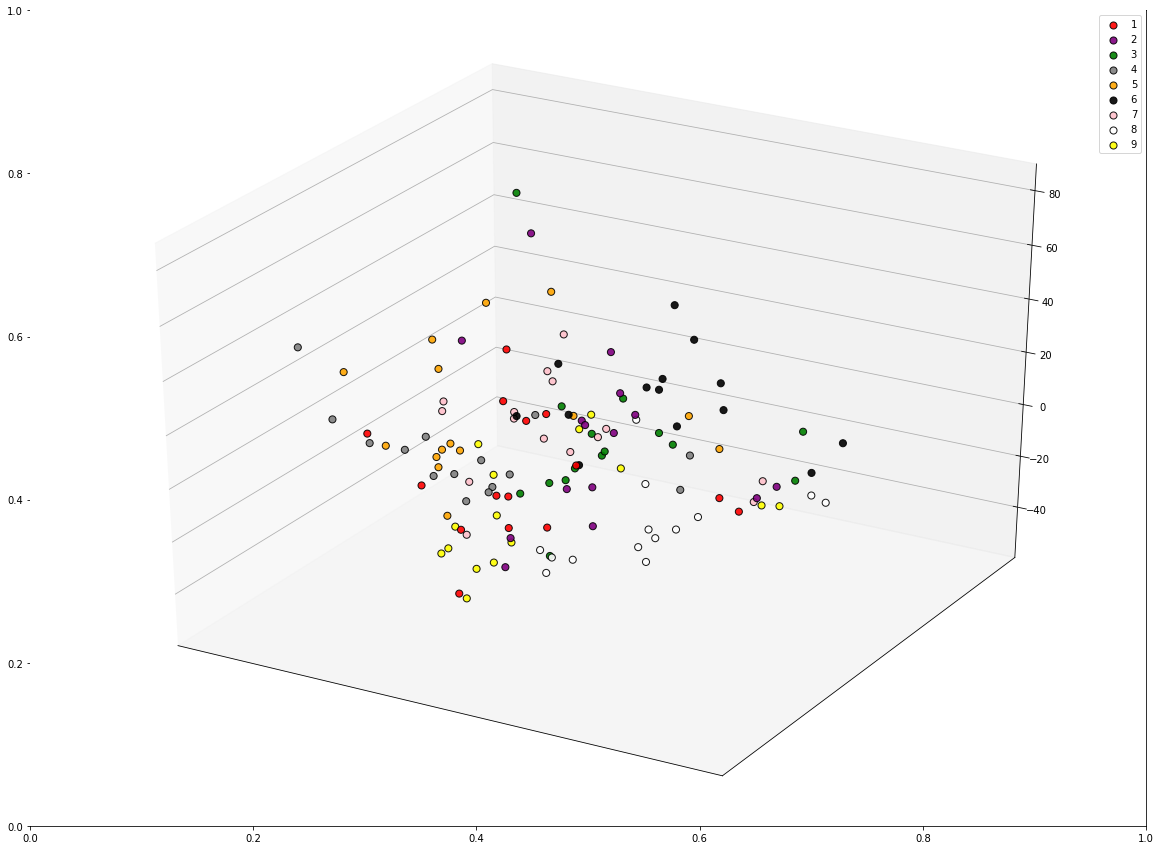

In [23]:
scatter_3d(X_3d, digit, [i for i in range(1,10)])

In [24]:
print(pca_2d.explained_variance_ratio_)
print(pca_3d.explained_variance_ratio_)

[0.58803289 0.11856749]
[0.58803289 0.11856749 0.10831836]


We observe that after dimensionality reduction we lost a lot of variance, that means that the whole procedure did not go well and we have lost useful information.

__Step 7:__ Classification

- Split data in train and test set in proportion 70%-30%

In [25]:
y = digit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

- Normalize our data

In [26]:
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

- Define the numpy based Gaussian classifier used in the 1st Lab.

In [27]:
class GaussianNB_np(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.classes = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior
        that contains the prior probability of each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        self.classes = np.unique(y)
        train_size, n_features = X.shape
        self.n_classes = len(self.classes)
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for k, c in enumerate(self.classes):
            idx_i = [i for i in range(train_size) if y[i] == c]
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[k, :] = np.mean(X_k, axis=0, keepdims=True)
            self.X_var_[k, :] = np.var(X_k, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        self.prior = np.zeros(self.n_classes)
        for k, c in enumerate(self.classes):
            self.prior[k] = np.count_nonzero(y == c) / train_size
        return self
        

    def predict(self, X, smooth=None):
        """
        Make predictions for X based on
        the highest posterior probability
        """

        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        # Define e for calculation stability (division by zero).
        if smooth:
            e = smooth
        else:
            e = 10**(-9)
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ e)) * \
                              np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + e))), axis=1)

        return np.argmax(like.T * self.prior, axis=1) + 1
    
    def score(self, X, y, smooth=None):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X, smooth)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

- Classify data using our custom Bayes from Lab 1.

In [28]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Define the classifier 
gaussNB_np = GaussianNB_np()
gaussNB_np.fit(X_train, y_train)

print("Accuracy of custom NumPy GaussianNB classifier")
print()

# Predict using default smoothing.
print("Smoothing 1e-9: " + str(gaussNB_np.score(X_test, y_test)))

# Predict using 1e-6 smoothing.
print("Smoothing 1e-6: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-6))))

# Predict using 1e-3 smoothing.
print("Smoothing 1e-3: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-3))))

# Predict using 1 smoothing.
print("Smoothing 1: " + str(gaussNB_np.score(X_test, y_test, smooth=1)))


Accuracy of custom NumPy GaussianNB classifier

Smoothing 1e-9: 0.65
Smoothing 1e-6: 0.65
Smoothing 1e-3: 0.65
Smoothing 1: 0.7


In [29]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Define the classifier 
gaussNB_np = GaussianNB_np()
gaussNB_np.fit(X_train_norm, y_train)

print("Accuracy of custom NumPy GaussianNB classifier  in normalized data")
print()

# Predict using default smoothing.
print("Smoothing 1e-9: " + str(gaussNB_np.score(X_test_norm, y_test)))

# Predict using 1e-6 smoothing.
print("Smoothing 1e-6: " + str(gaussNB_np.score(X_test_norm, y_test, smooth=10**(-6))))

# Predict using 1e-3 smoothing.
print("Smoothing 1e-3: " + str(gaussNB_np.score(X_test_norm, y_test, smooth=10**(-3))))

# Predict using 1 smoothing.
print("Smoothing 1: " + str(gaussNB_np.score(X_test_norm, y_test, smooth=1)))


Accuracy of custom NumPy GaussianNB classifier  in normalized data

Smoothing 1e-9: 0.6
Smoothing 1e-6: 0.675
Smoothing 1e-3: 0.45
Smoothing 1: 0.15


- Classify data using Naive Bayes of sklearn.

In [30]:
gaussNB = GaussianNB()

gaussNB.fit(X_train, y_train)

print("Accuracy of sklearn GaussianNB classifier")
print()

print(gaussNB.score(X_test, y_test))

Accuracy of sklearn GaussianNB classifier

0.65


In [31]:
gaussNB = GaussianNB()

gaussNB.fit(X_train_norm, y_train)

print("Accuracy of sklearn GaussianNB classifier in normalized data")
print()

print(gaussNB.score(X_test_norm, y_test))

Accuracy of sklearn GaussianNB classifier in normalized data

0.6


- Classify data using Nearest Neighbors classifier

In [32]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

print("Accuracy of Nearest Neihbors classifier")
print()

print(neigh.score(X_test, y_test))

Accuracy of Nearest Neihbors classifier

0.625


In [33]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_norm, y_train)

print("Accuracy of Nearest Neihbors classifier in normalized data")
print()

print(neigh.score(X_test_norm, y_test))

Accuracy of Nearest Neihbors classifier in normalized data

0.55


- Classify data using SVM classifier with linear kernel.

In [34]:
svm_linear = SVC(kernel="linear", probability=True) 
svm_linear.fit(X_train, y_train)

print("Accuracy of SVM classifier, using linear kernel")
print()

print(svm_linear.score(X_test, y_test))

Accuracy of SVM classifier, using linear kernel

0.875


In [35]:
svm_linear = SVC(kernel="linear", probability=True) 
svm_linear.fit(X_train_norm, y_train)

print("Accuracy of SVM classifier, using linear kernel in normalized data")
print()

print(svm_linear.score(X_test_norm, y_test))

Accuracy of SVM classifier, using linear kernel in normalized data

0.25


- Classify data using SVM classifier with poly kernel.

In [36]:
svm_poly = SVC(kernel="poly", probability=True) 
svm_poly.fit(X_train, y_train)

print("Accuracy of SVM classifier, using poly kernel")
print()

print(svm_poly.score(X_test, y_test))

Accuracy of SVM classifier, using poly kernel

0.85


In [37]:
svm_poly = SVC(kernel="poly", probability=True) 
svm_poly.fit(X_train_norm, y_train)

print("Accuracy of SVM classifier, using poly kernel in normalized data")
print()

print(svm_poly.score(X_test_norm, y_test))

Accuracy of SVM classifier, using poly kernel in normalized data

0.25


- Classify data using Logistic Regression.

In [38]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print("Accuracy of Logistic Regression classifier")
print()

print(log_reg.score(X_test, y_test))

Accuracy of Logistic Regression classifier

0.825


In [39]:
log_reg = LogisticRegression()
log_reg.fit(X_train_norm, y_train)

print("Accuracy of Logistic Regression classifier in normalized data")
print()

print(log_reg.score(X_test_norm, y_test))

Accuracy of Logistic Regression classifier in normalized data

0.25


- Summarize our results in the following table:

|    Classifier    |   Parameter     | Normalized | Accuracy |
| ---------------- | --------------- | ---------- | -------- |
|    Bayes_np      |  smooth=1e-6    |    No      |    65    |
|    Bayes_np      |  smooth=1e-6    |    Yes     |    67.5  |
|  Bayes_sklearn   |  smooth=1e-9    |    No      |    65    |
|  Bayes_sklearn   |  smooth=1e-9    |    Yes     |    60    |
| Nearest Neighbor |      n = 3      |    No      |    62.5  |
| Nearest Neighbor |      n = 3      |    Yes     |    55    |
|      SVM         | kernel = linear |    No      |    87.5  |
|      SVM         | kernel = linear |    Yes     |    25    |
|      SVM         | kernel = poly   |    No      |    85    |
|      SVM         | kernel = poly   |    Yes     |    25    |
|      Logistic    |        -        |    No      |    82.5  |
|      Logistic    |        -        |    Yes     |    25    |

__Step 8:__ Pytorch introduction

- Generate 10-point sin and cosine waves with f = 40 Hz and random amplitude.

In [40]:
f = 40
step = 0.001
X = np.zeros((1000, 10))
y = np.zeros((1000, 10))

for i in range(1000):
    # Random amplitude in range [0, 10]
    A = np.random.rand()*10
    # Random starting point in range [0, 40T]
    start = np.random.rand() * (40/f)
    time = np.linspace(start, start+step*10, num=10)
    X[i] = A*np.sin(2*np.pi*f*time)
    y[i] =  A*np.cos(2*np.pi*f*time)
    


- Plot some samples from our generated dataset

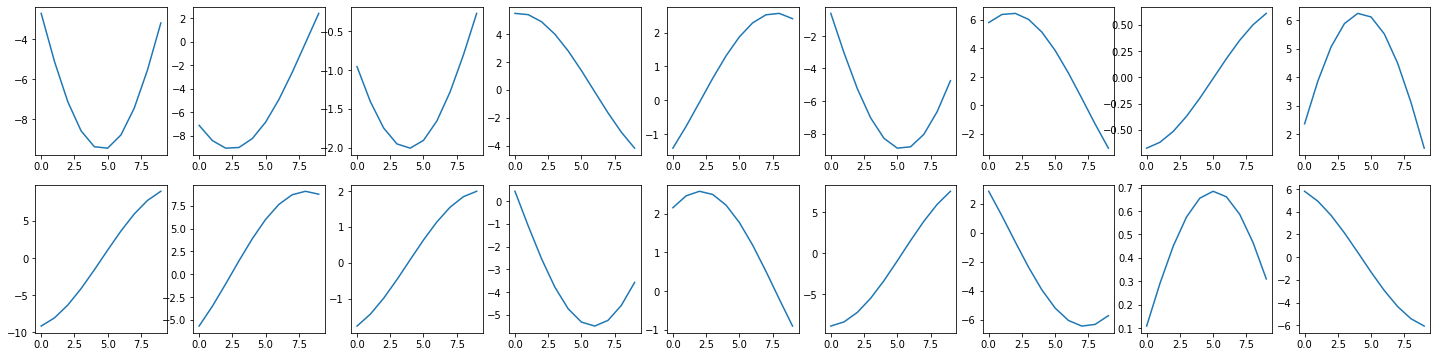

In [41]:
# Define a figure with 10 plots.
fig = plt.figure(figsize=(25,6))
columns = 9

samples = [100, 200, 300, 400, 500, 600, 700, 800, 900]

for i in range(9):
    # Display the randomly selected image in a subplot
    fig.add_subplot(2, columns, i+1)
    plt.plot(np.arange(10), X[samples[i]])

for i in range(9):
    # Display the randomly selected image in a subplot
    fig.add_subplot(2, columns, i+10)
    plt.plot(np.arange(10), y[samples[i]])

    
plt.show()

- Split data in train and test set and convert them in tensors.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

- Define an LSTM

In [43]:
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTMCell(1, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

- Define model parameters

In [44]:
model = LSTMNet().double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

- Train the model

In [45]:
train_losses = []
test_losses = []

epochs = 1500
for i in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    if i%100 == 0:
        print('Train loss', loss.item())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        pred = model(X_test)
        loss = criterion(pred, y_test)
        if i%100 == 0:
            print('Test loss:', loss.item())
            print()
        test_losses.append(loss.item())

Train loss 15.511579396452419
Test loss: 16.090322915840076

Train loss 5.845409319367895
Test loss: 6.215907871468672

Train loss 3.157679880125952
Test loss: 3.2899512977348446

Train loss 2.3139853237811963
Test loss: 2.386515250438525

Train loss 1.9955024914881492
Test loss: 2.045997617949256

Train loss 1.825739014773939
Test loss: 1.8537379050886345

Train loss 1.7338604531535549
Test loss: 1.7453813927662707

Train loss 1.6876910520463968
Test loss: 1.6915963811208405

Train loss 1.6654334869308427
Test loss: 1.669099478299471

Train loss 1.653769714374051
Test loss: 1.6608352317218886

Train loss 1.646817736847007
Test loss: 1.6578933838793715

Train loss 1.6424404716899885
Test loss: 1.6571492725914432

Train loss 1.639410700674696
Test loss: 1.6569210468816182

Train loss 1.6372718512420668
Test loss: 1.6568424086735403

Train loss 1.6357765562700537
Test loss: 1.6567585519525028



In [46]:
train_losses

[15.511579396452419,
 15.396350748711336,
 15.282759247424247,
 15.169924304926537,
 15.056895556154888,
 14.942640531868397,
 14.82603069180631,
 14.705910656954362,
 14.581128504511284,
 14.450536170154185,
 14.312972907440535,
 14.167245461215341,
 14.012123829284203,
 13.846357451979062,
 13.66870699960064,
 13.477987799062095,
 13.273127232815707,
 13.053237322947476,
 12.817706694614532,
 12.56631233152334,
 12.299344736238991,
 12.017736247508134,
 11.723183834275883,
 11.418259858575562,
 11.106503492768262,
 10.792483842352855,
 10.481811805253688,
 10.181054495302314,
 9.897469452332544,
 9.63844124258761,
 9.410585345363396,
 9.2187227769482,
 9.0651636837172,
 8.949584793566702,
 8.869106913996594,
 8.818358625069996,
 8.790037087107383,
 8.775968710973324,
 8.76808253612624,
 8.759063305877694,
 8.742884123132681,
 8.715243018648792,
 8.673790582432655,
 8.618119184066288,
 8.549543074313434,
 8.470719089382348,
 8.385172271552257,
 8.29679406832086,
 8.209366627052045,
 8

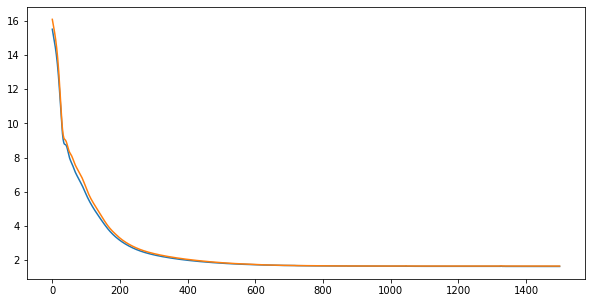

In [47]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(test_losses)), test_losses)

- Plot some test predictions

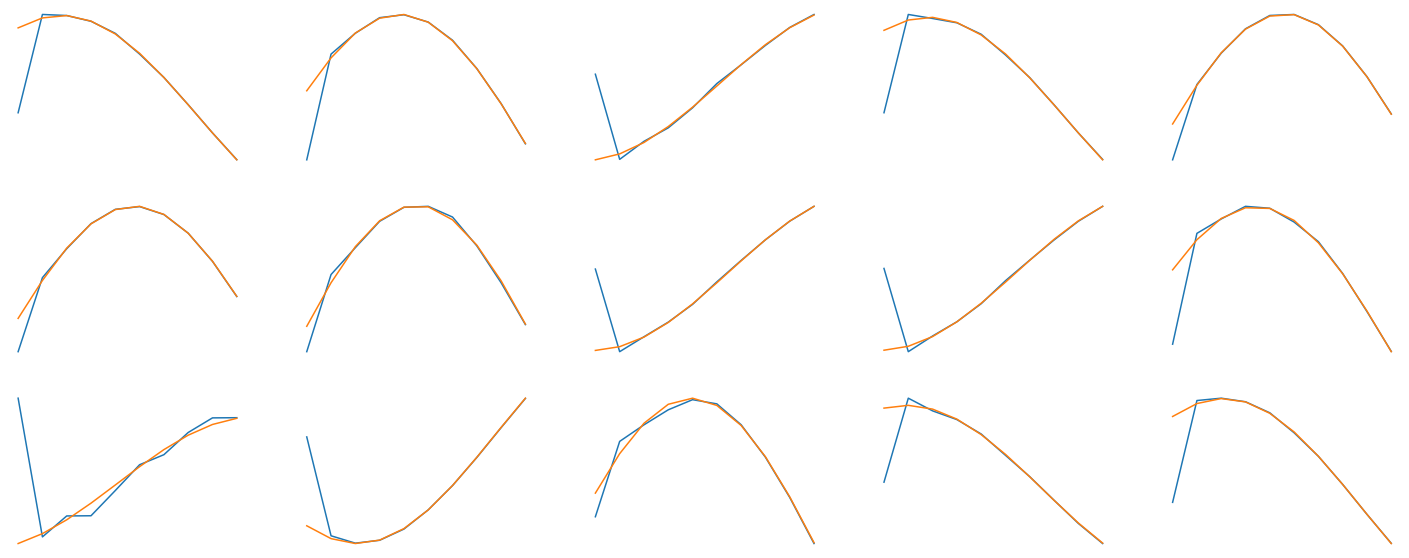

In [48]:
# Define a figure with 10 plots.
fig = plt.figure(figsize=(25,10))
columns = 5
rows = 3

samples = np.random.randint(0, 200, 15)

for i in range(15):
    # Display the randomly selected image in a subplot
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    with torch.no_grad():
        pred = model(X_test[samples[i]].view(1,-1))
    plt.plot(np.arange(10), pred[0])
    plt.plot(np.arange(10), y_test[samples[i]])
    


We observe that the cosine prediction is very successful. The only point that is not predicted properly is the first, because the model has not enough data at this time.

#### The next steps are implemented as part of the main lab

For the main part of the Lab, a larger dataset will be used, the Free Spoken Digit Dataset (FSDD), located [here](https://github.com/Jakobovski/free-spoken-digit-dataset). In __pr_lab2_2019-20_help_scripts__ some help scripts are provided, that will be used though the notebook.

Import more libraries

In [84]:
from glob import glob
import librosa as l
import os
from sklearn.preprocessing import StandardScaler
from pomegranate import *
import itertools
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score

The following function is provided in __./pr_lab2_2019-20_help_scripts/parser.py__ and implements the whole procedure of reading data, extracting MFCCs, normalizing and splitting data in train and test set.

In [50]:
def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split('/')[1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = l.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = l.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [l.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

Read data from __./recordings__ file using above function.

In [51]:
data_dir = 'recordings'
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(data_dir)

Total wavs: 2000


Keep the number of extracted MFCCs.

In [52]:
# Each sample is a 2d NumPy array that each row represents a frame and each collumn represents a MFCC.
_, num_mfcc = X_train[0].shape

print("Number of MFCCs: %d" %num_mfcc)

Number of MFCCs: 6


__Step 9:__ Split train data in training and validation set in proportion 80%-20%. Use stratified split, in order to preserve the label distribution in each set.

In [53]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [54]:
train_size = len(X_tr)
val_size = len(X_val)
test_size = len(X_test) 

print("Train set size: %d" %train_size)
print("Validation set size: %d" %val_size)
print("Test set size: %d" %test_size)

Train set size: 1440
Validation set size: 360
Test set size: 200


__Step 10:__ Digit Recognition using GMM-HMM (Gaussian Mixture Models – Hidden Markov Models).

In this Step, we will use [pomegranate](https://pomegranate.readthedocs.io/en/latest/). Initialize a GMM-HMM for every digit, as follows:
- In the transition matrix, $a_{i, j} = 0$ if $j<i$ or $j > i+1$, because the only allowed transitions are between successive states.
- For the initial probabilities, $\pi_i = \begin{cases} 0, \ i \neq 0 \\ 1, \ i=1 \end{cases}$
- Αn acoustic feature vector, extracted from the processing of a speech frame (MFCC), is a possible observation in a state of the HMM-GMM.

Define a function that defines and trains a GMM-HMM for a single digit, based on the above assumptions.

In [55]:
def train_hmm(X, n_states, n_mixtures, gmm, max_iter):
    dists = [] # list of probability distributions for the HMM states
    X_stacked = np.vstack(X) # stack all frames of current digit in a single 2d numpy array
    for i in range(n_states):
        if gmm and n_mixtures>1:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, np.float_(X_stacked))
        else:
            a = MultivariateGaussianDistribution.from_samples(np.float_(X_stacked))
        dists.append(a)

    trans_mat = np.zeros((n_states, n_states)) # transition matrix
    for i in range(n_states):
        for j in range(n_states):
            if i == j or j == i+1:
                trans_mat[i, j] = 0.5 # uniformly
    starts =  numpy.zeros(n_states) # starting probability matrix
    starts[0] = 1
    ends = np.zeros(n_states) # ending probability matrix
    ends[-1] = 1

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])

    # Fit the model
    model.fit(X, max_iterations=max_iter)
    
    return model

Define a list that keeps in index i the recordings of the digit i.

In [56]:
X_tr_per_digit = []
for digit in range(10):
    X_tr_i = np.take(X_tr, [i for i in range(train_size) if y_tr[i] == digit], axis=0)
    X_tr_per_digit.append(X_tr_i)

__Step 11:__ Train 10 models using the algorithm Expectation - Maximization. The algorithm runs for a predefined number of iterations or until the log-likelihood has converged. In pomegranate, we use the fit method.

__Step 11:__ Define a function that trains 10 models using E-M algorithm for a specific number of iterations or until convergence.

In [57]:
def train_models(X, n_states, n_mixtures, gmm, max_iter):
    models = []
    for i in range(10):
        models.append(train_hmm(X[i], n_states, n_mixtures, gmm, max_iter))
    return models

__Step 12:__ Testing: Compute the log likelihood for each recording of the validation set. For a single recording, the decoding digit is the one with the highest log likelihood.

Define a function that takes the trained models and evaluate them in the validation set.

In [58]:
def eval_models(models, X_val, y_val, n):
    cm = np.zeros((10, 10)) # confusion matrix
    y_preds = np.zeros(n, dtype='int') # predictions
    for i in range(n):
        logs = np.zeros(10)
        # Evaluate the sample in each model and decode it to the digit with the highest log-likelihood.
        for j in range(10):
            logp, _ = models[j].viterbi(X_val[i]) # Run viterbi algorithm and return log-probability
            logs[j] = logp
        y_preds[i] = np.argmax(logs)
        cm[y_val[i], y_preds[i]] += 1
    acc = sum(y_preds == y_val) / n
    
    return acc, cm

Define hyperparameters to select the best model.

In [59]:
n_states_ = [1, 2, 3, 4]
n_mixtures_ = [1, 2, 3, 4, 5]
max_iter_ = [10, 15, 20, 25]

Evaluate all possible models in the validation set.

In [60]:
accs = []
for n_states in n_states_:
    for n_mixtures in n_mixtures_:
        for max_iter in max_iter_:
            models = train_models(X_tr_per_digit, n_states, n_mixtures, True, max_iter)
            acc, _ = eval_models(models, X_val, y_val, val_size)
            accs.append(acc)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


Because of undesired warnings in the output, we kept the results in a list.

In [61]:
for i, n_states in enumerate(n_states_):
    for j, n_mixtures in enumerate(n_mixtures_):
        for k, max_iter in enumerate(max_iter_):
            print("states:%d, Gaussians:%d, max-iterations:%d has %f accuracy" %(n_states, n_mixtures, max_iter, accs[i+j+k]))

states:1, Gaussians:1, max-iterations:10 has 0.897222 accuracy
states:1, Gaussians:1, max-iterations:15 has 0.897222 accuracy
states:1, Gaussians:1, max-iterations:20 has 0.897222 accuracy
states:1, Gaussians:1, max-iterations:25 has 0.897222 accuracy
states:1, Gaussians:2, max-iterations:10 has 0.897222 accuracy
states:1, Gaussians:2, max-iterations:15 has 0.897222 accuracy
states:1, Gaussians:2, max-iterations:20 has 0.897222 accuracy
states:1, Gaussians:2, max-iterations:25 has 0.927778 accuracy
states:1, Gaussians:3, max-iterations:10 has 0.897222 accuracy
states:1, Gaussians:3, max-iterations:15 has 0.897222 accuracy
states:1, Gaussians:3, max-iterations:20 has 0.927778 accuracy
states:1, Gaussians:3, max-iterations:25 has 0.938889 accuracy
states:1, Gaussians:4, max-iterations:10 has 0.897222 accuracy
states:1, Gaussians:4, max-iterations:15 has 0.927778 accuracy
states:1, Gaussians:4, max-iterations:20 has 0.938889 accuracy
states:1, Gaussians:4, max-iterations:25 has 0.941667 a

Evaluate the best model in test set.

In [63]:
n_states_best = 4
n_mixtures_best = 5
max_iter_best = 25

best_models = train_models(X_tr_per_digit, n_states_best, n_mixtures_best, True, max_iter_best)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


In [64]:
acc_val, cm_val = eval_models(best_models, X_val, y_val, val_size)
print("Accuracy of best model in validation set: %f" %acc_val)
acc_test, cm_test = eval_models(best_models, X_test, y_test, test_size)
print("Accuracy of best model in test set: %f" %acc_test)

Accuracy of best model in validation set: 0.986111
Accuracy of best model in test set: 0.960000


In order to select the best model, we validate different models in the validation set and we tune the hyperparameters. The accuracy estimate of the final model on validation data will be biased since the validation set is used to select the final model. After assessing the final model on the test set, we must not tune the model any further.

__Step 13:__ Plot the confusion matrix for the validation and the test set.

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.97222222 0.         0.         0.
  0.         0.02777778 0.         0.        ]
 [0.         0.         0.08333333 0.91666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.97222222 0.         0.02777778]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.     

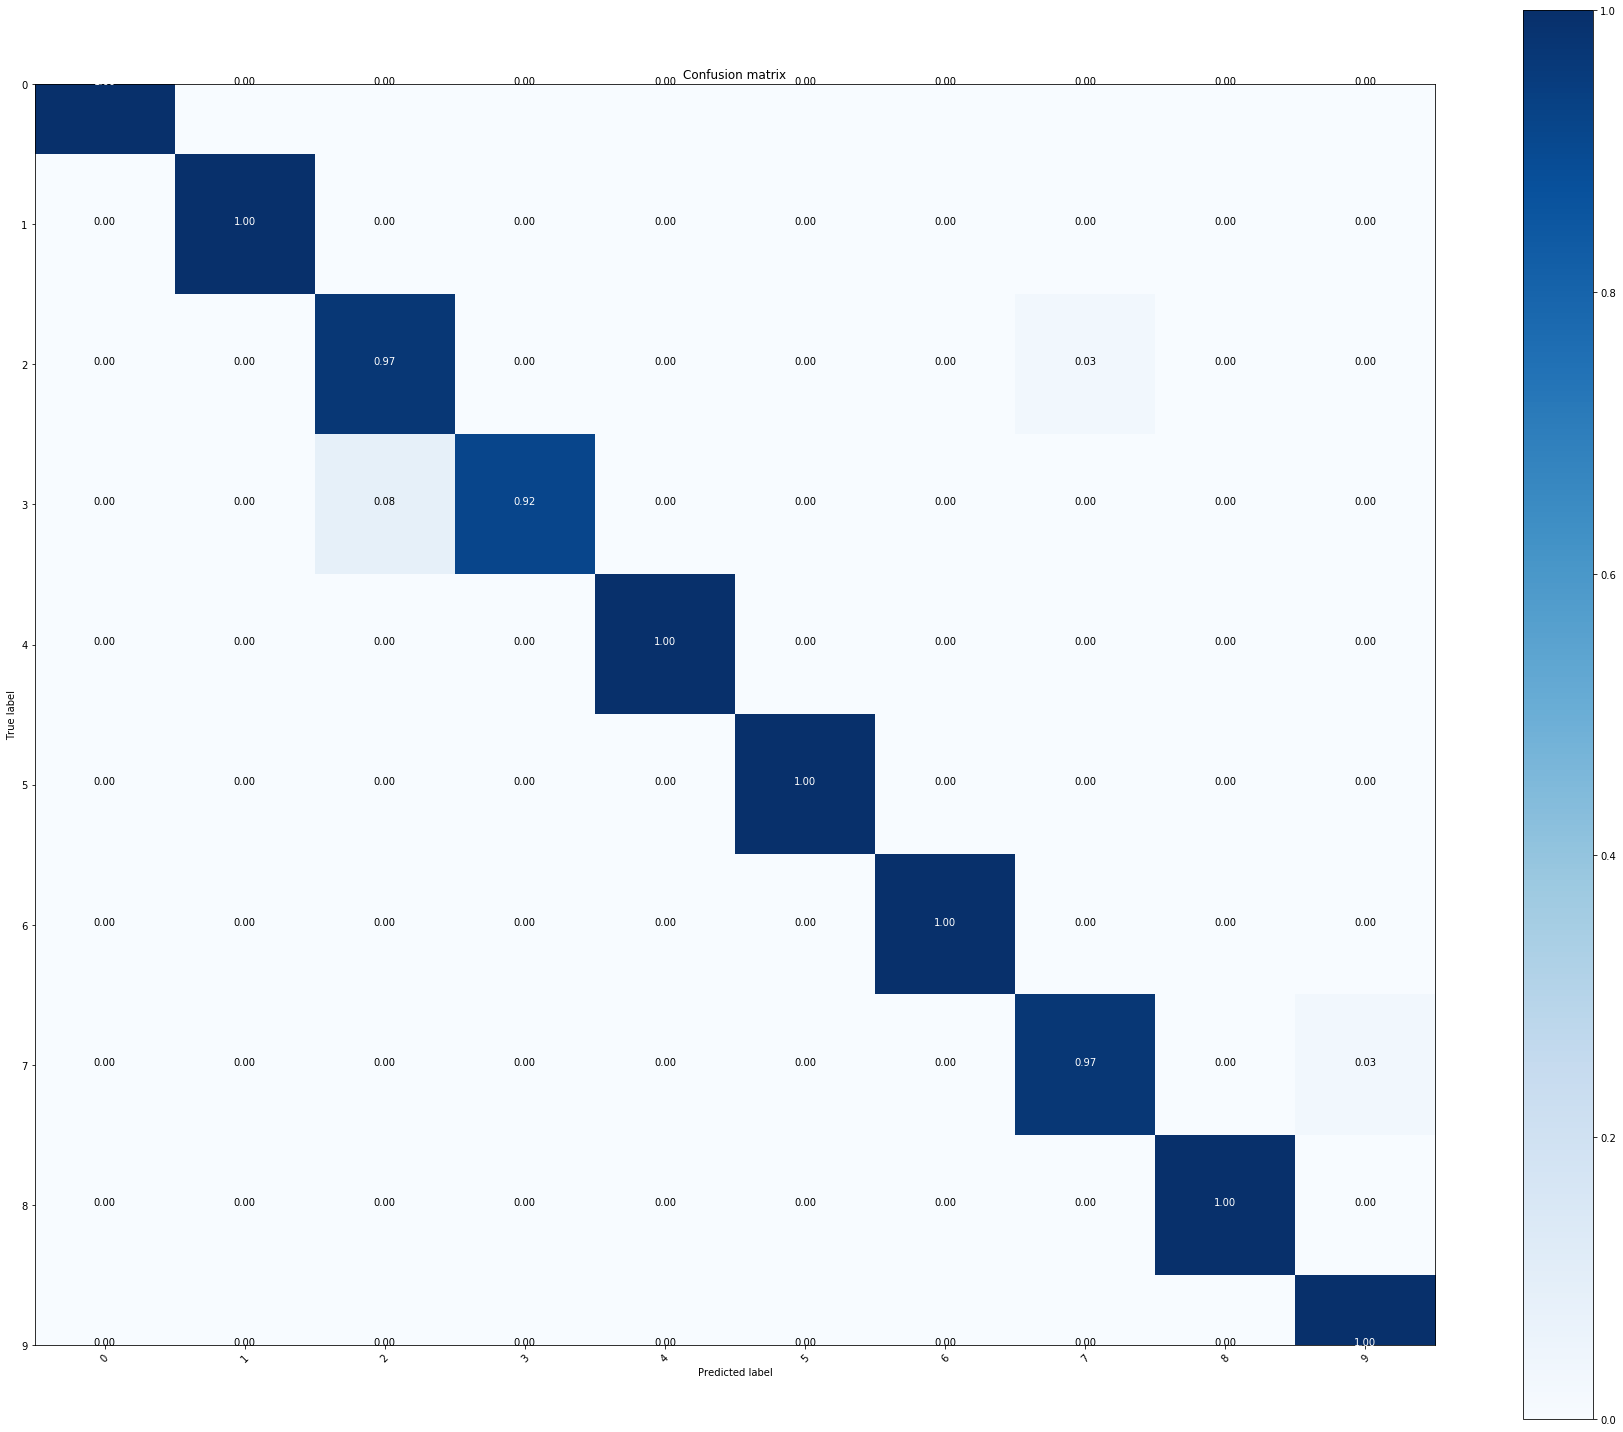

In [66]:
plt.rcParams['figure.figsize'] = [25, 20]
plot_confusion_matrix(cm_val, [i for i in range(10)], normalize=True)

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.95 0.   0.   0.   0.05 0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.05 0.   0.   0.95 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.15 0.   0.   0.85 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.05 0.   0.   0.05 0.   0.9  0.  ]
 [0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.95]]


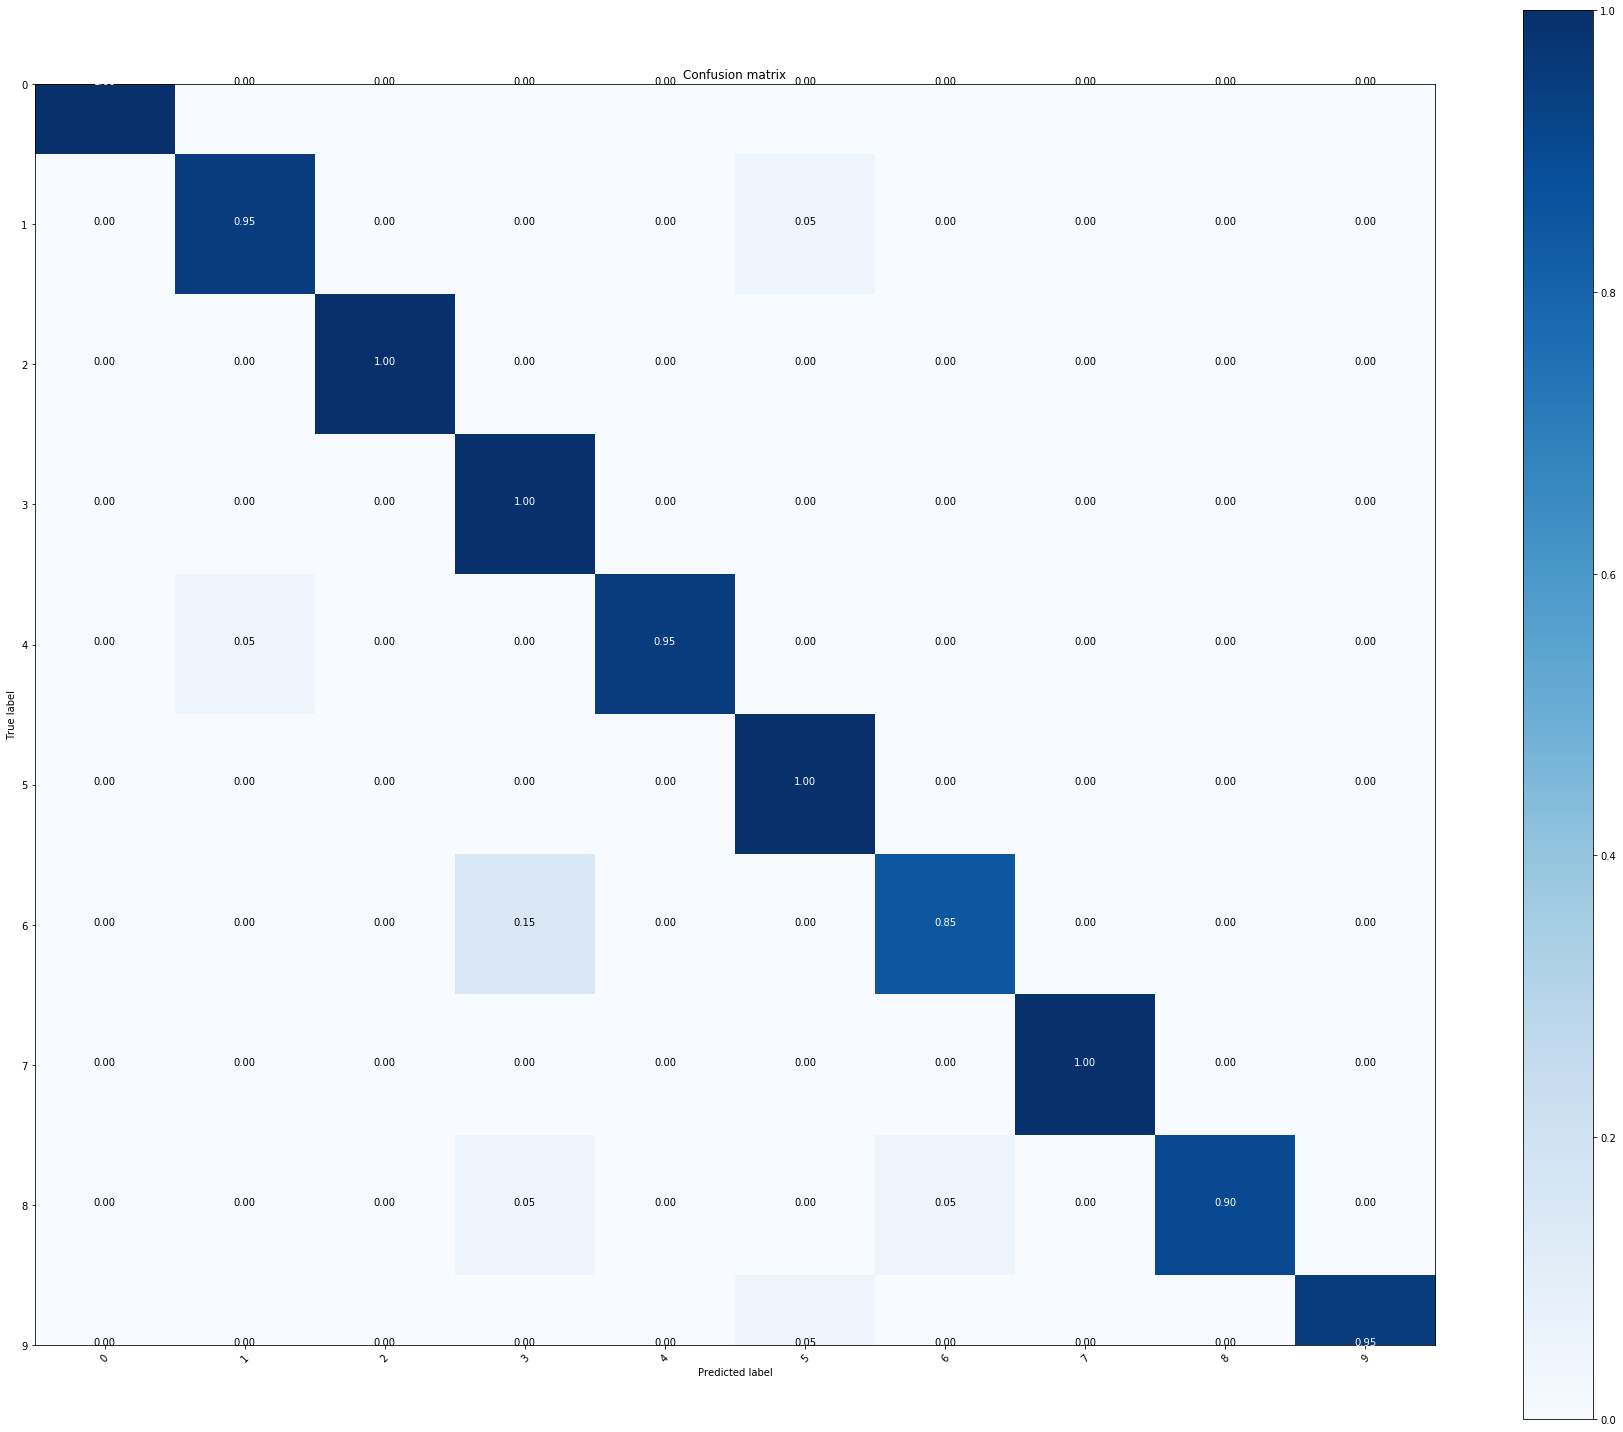

In [67]:
plot_confusion_matrix(cm_test, [i for i in range(10)], normalize=True)

__Step 14:__ Train a Recurrent Neural Network in the training set and use the validation set to configure the hyperparameters

- Define a PyTorch Dataset

In [69]:
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths =  [len(example) for example in feats] 

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        max_length = max(self.lengths)
        padded = np.array([np.pad(example, ((0, max_length-len(example)), (0, 0))) for example in x])

        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)



- Define datasets for both train, validation and test set.

In [70]:
train_set = FrameLevelDataset(X_tr, y_tr)
val_set = FrameLevelDataset(X_val, y_val)
test_set = FrameLevelDataset(X_test, y_test)

- Define a train, a validation and a test DataLoader

In [71]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)

- Define LSTM

In [72]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False, dropout=0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_size = rnn_size
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, self.rnn_size, self.num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Forward propagate Linear
        last_outputs = self.linear(self.last_timestep(lstm_out, lengths, self.bidirectional))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1).to(DEVICE)
        return outputs.gather(1, idx).squeeze()

- Define a function that trains the model for an epoch.

In [73]:
def train_dataset(_epoch, dataloader, model, loss_function, optimizer):
    # IMPORTANT: switch to train mode
    # Εnable regularization layers, such as Dropout
    model.train()
    running_loss = 0.0

    # Οbtain the model's device ID
    device = next(model.parameters()).device

    for index, batch in enumerate(dataloader, 1):
        # Get the inputs (batch)
        inputs, labels, lengths = batch

        # Move the batch tensors to the right device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Step 1 - zero the gradients
        # Remember that PyTorch accumulates gradients.
        # We need to clear them out before each batch!
        optimizer.zero_grad()

        # Step 2 - forward pass: y' = model(x)
        y_preds = model(inputs, lengths)

        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(y_preds, labels)

        # Step 4 - backward pass: compute gradient wrt model parameters
        loss.backward()

        # Step 5 - update weights
        optimizer.step()

        # Accumulate loss in a variable.
        running_loss += loss.data.item()

    return running_loss / index

- Define a function that evaluates the model in an epoch.

In [113]:
def eval_dataset(dataloader, model, loss_function):
    # IMPORTANT: switch to eval mode
    # Disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # Obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()

    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):
            # Get the inputs (batch)
            inputs, labels, lengths = batch

            # Step 1 - move the batch tensors to the right device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Step 2 - forward pass: y' = model(x)
            y_preds = model(inputs, lengths)  # EX9

            # Step 3 - compute loss: L = loss_function(y, y')
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time
            loss = loss_function(y_preds, labels)

            # Step 4 - make predictions (class = argmax of posteriors)
            y_preds_arg = torch.argmax(y_preds, dim=1)

            # Step 5 - collect the predictions, gold labels and batch loss
            y_pred.append(y_preds_arg.cpu().numpy())
            y.append(labels.cpu().numpy())

            # Accumulate loss in a variable
            running_loss += loss.data.item()
    return running_loss / index, (y, y_pred)

- Train the network, printing only the training loss in each epoch.

In [114]:
RNN_SIZE = 32
EPOCHS = 50

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
total_train_loss = [] 

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    # Evaluate the performance of the model, on train set
    train_loss, _ = eval_dataset(train_loader, model, loss_function)
    print(train_loss)
    total_train_loss.append(train_loss)

2.2548021233600117
2.1393308639526367
1.9125279861947764
1.6809730633445408
1.4807264545689458
1.2941934129466182
1.1248961946238643
0.9672743496687516
0.8394994683887648
0.7366554192874742
0.7062136116235153
0.6280309817065364
0.5699848130993221
0.5156763597674991
0.4683869597704514
0.4344853590364042
0.39102950303450873
0.3578003308047419
0.33352292296679126
0.30046095018801483
0.27484572322472284
0.3129508035338443
0.26673041672810266
0.25106040226376575
0.22388093497442163
0.21001901186030844
0.20169018824463306
0.19623839207317517
0.17398956353249756
0.17538324840690778
0.1631898507475853
0.15346836881793063
0.14325002127367517
0.13790800778762155
0.13075587380191553
0.14045364020959192
0.12451080378630887
0.12062795913737753
0.11469108060650203
0.11616416340288908
0.10800292861202489
0.1034806048416573
0.1043877888308919
0.10795050681285236
0.09675616495635199
0.12369051770023677
0.1230851766531882
0.11274049479676329
0.09697726320313371
0.08632503935824269


Plot the losses in the training set.

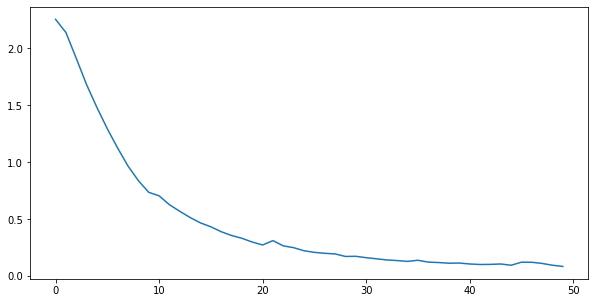

In [115]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(total_train_loss)

Validate the trained model in validation set.

In [117]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.222503
Accuracy: 0.944444


- Train the network, printing both the training and the validation loss in each epoch.

In [118]:
RNN_SIZE = 32
EPOCHS = 50

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 1)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
total_train_loss = []
total_val_loss = []

for i in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)
    print()

Train: 2.255378
Validation: 2.256049

Train: 2.136063
Validation: 2.138448

Train: 1.843979
Validation: 1.833493

Train: 1.601668
Validation: 1.601718

Train: 1.405777
Validation: 1.406196

Train: 1.216260
Validation: 1.232647

Train: 1.056683
Validation: 1.085333

Train: 0.916265
Validation: 0.955457

Train: 0.816915
Validation: 0.875544

Train: 0.727113
Validation: 0.777854

Train: 0.631796
Validation: 0.705752

Train: 0.574057
Validation: 0.614433

Train: 0.508750
Validation: 0.537069

Train: 0.468098
Validation: 0.527629

Train: 0.452078
Validation: 0.526292

Train: 0.404013
Validation: 0.486756

Train: 0.342529
Validation: 0.411021

Train: 0.326749
Validation: 0.381801

Train: 0.286094
Validation: 0.366171

Train: 0.276684
Validation: 0.337901

Train: 0.257839
Validation: 0.336055

Train: 0.236729
Validation: 0.322326

Train: 0.223466
Validation: 0.288602

Train: 0.214211
Validation: 0.277216

Train: 0.213369
Validation: 0.285265

Train: 0.189397
Validation: 0.258656

Train: 0.177

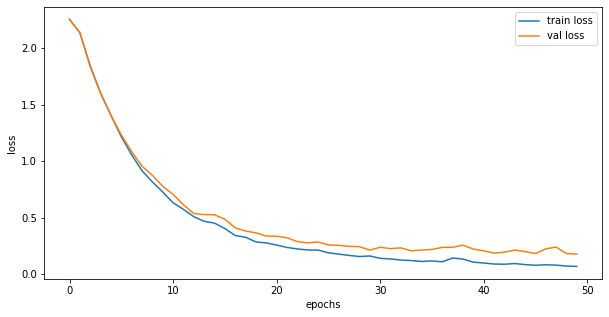

In [119]:
x = np.arange(EPOCHS)
plt.plot(x, total_train_loss, label = "train loss")
plt.plot(x, total_val_loss, label = "val loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

- Add Dropout and L2 Regulatization in the model

- __Dropout:__ Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

- __L2 Regularization:__ Regularization adds a penalty as model complexity increases. Regularization parameter (lambda) penalizes all the parameters except intercept so that model generalizes the data and won’t overfit.

Both methods prevent overfitting.

In [120]:
RNN_SIZE = 32
EPOCHS = 50

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

total_train_reg_loss = []
total_val_reg_loss = []

for i in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_reg_loss.append(train_loss)
    total_val_reg_loss.append(val_loss)
    print()


Train: 2.266654
Validation: 2.269062

Train: 2.003991
Validation: 2.015907

Train: 1.566077
Validation: 1.577507

Train: 1.136181
Validation: 1.153025

Train: 0.889251
Validation: 0.915742

Train: 0.676791
Validation: 0.707718

Train: 0.570114
Validation: 0.620827

Train: 0.476043
Validation: 0.516993

Train: 0.421707
Validation: 0.464358

Train: 0.375894
Validation: 0.423722

Train: 0.314722
Validation: 0.379471

Train: 0.281137
Validation: 0.357459

Train: 0.255764
Validation: 0.329751

Train: 0.228541
Validation: 0.287110

Train: 0.223552
Validation: 0.301406

Train: 0.200422
Validation: 0.288889

Train: 0.183496
Validation: 0.259490

Train: 0.161150
Validation: 0.222800

Train: 0.162591
Validation: 0.220619

Train: 0.144442
Validation: 0.193665

Train: 0.135532
Validation: 0.201352

Train: 0.121336
Validation: 0.171083

Train: 0.107888
Validation: 0.166979

Train: 0.103329
Validation: 0.199576

Train: 0.095306
Validation: 0.172088

Train: 0.100041
Validation: 0.128927

Train: 0.109

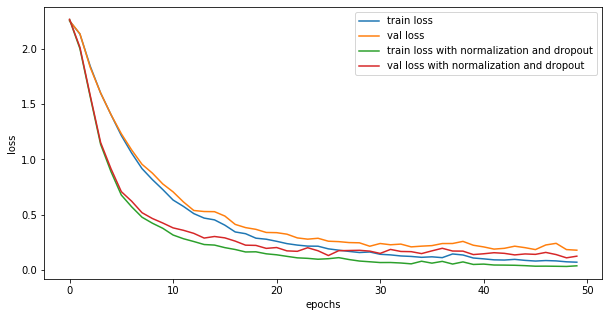

In [121]:
x = np.arange(EPOCHS)
plt.plot(x, total_train_loss, label = "train loss")
plt.plot(x, total_val_loss, label = "val loss")
plt.plot(x, total_train_reg_loss, label = "train loss with normalization and dropout")
plt.plot(x, total_val_reg_loss, label = "val loss with normalization and dropout")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [122]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.122361
Accuracy: 0.969444


- Train the network using Early Stoping and Checkpoints.

In [123]:
RNN_SIZE = 32
EPOCHS = 150

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
n_epochs_stop = 10
min_val_loss = 1000
epochs_no_improve = 0

total_train_reg_loss_early = []
total_val_reg_loss_early = []

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(model, "./model")
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
            
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_reg_loss_early.append(train_loss)
    total_val_reg_loss_early.append(val_loss)
    print()

Train: 2.260597
Validation: 2.260723

Train: 1.999084
Validation: 1.990664

Train: 1.585876
Validation: 1.594911

Train: 1.269796
Validation: 1.290804

Train: 1.021167
Validation: 1.060195

Train: 0.836254
Validation: 0.867308

Train: 0.707374
Validation: 0.770993

Train: 0.593189
Validation: 0.673521

Train: 0.486960
Validation: 0.547353

Train: 0.405272
Validation: 0.474838

Train: 0.341807
Validation: 0.426352

Train: 0.301507
Validation: 0.387148

Train: 0.255170
Validation: 0.354502

Train: 0.229288
Validation: 0.313002

Train: 0.208372
Validation: 0.288993

Train: 0.168665
Validation: 0.269412

Train: 0.158465
Validation: 0.242311

Train: 0.153948
Validation: 0.237980

Train: 0.139717
Validation: 0.245936

Train: 0.134150
Validation: 0.222793

Train: 0.120996
Validation: 0.209933

Train: 0.099807
Validation: 0.209646

Train: 0.114651
Validation: 0.192005

Train: 0.098836
Validation: 0.195333

Train: 0.085394
Validation: 0.181046

Train: 0.087348
Validation: 0.176051

Train: 0.077

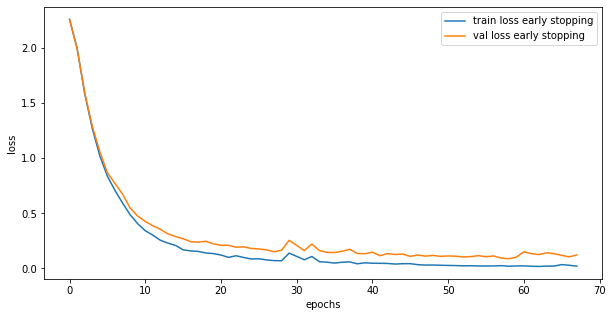

In [124]:
x = np.arange(epoch)
plt.plot(x, total_train_reg_loss_early, label = "train loss early stopping")
plt.plot(x, total_val_reg_loss_early, label = "val loss early stopping")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [125]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.099820
Accuracy: 0.966667


As we can see early stopping helped us train our network for many epochs until the model starts to overfit.

- Train a bidirectional LSTM.

Using bidirectional will run the inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards you preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future.

In [127]:
RNN_SIZE = 32
EPOCHS = 150

model = BasicLSTM(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
n_epochs_stop = 10
min_val_loss = 1000
epochs_no_improve = 0

total_train_bid = []
total_val_bid = []

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(model, "./model_bid")
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
            
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_bid.append(train_loss)
    total_val_bid.append(val_loss)
    print()

Train: 2.202593
Validation: 2.204439

Train: 1.666670
Validation: 1.671046

Train: 0.955918
Validation: 0.938876

Train: 0.599660
Validation: 0.605506

Train: 0.399529
Validation: 0.433762

Train: 0.299418
Validation: 0.349620

Train: 0.224104
Validation: 0.301893

Train: 0.207799
Validation: 0.245146

Train: 0.159552
Validation: 0.234760

Train: 0.133179
Validation: 0.196185

Train: 0.116685
Validation: 0.178938

Train: 0.113704
Validation: 0.198654

Train: 0.091342
Validation: 0.169568

Train: 0.095859
Validation: 0.170799

Train: 0.077191
Validation: 0.148203

Train: 0.081719
Validation: 0.154710

Train: 0.069865
Validation: 0.126222

Train: 0.080337
Validation: 0.117871

Train: 0.062214
Validation: 0.131096

Train: 0.048661
Validation: 0.098594

Train: 0.066059
Validation: 0.112501

Train: 0.041541
Validation: 0.096573

Train: 0.038225
Validation: 0.118951

Train: 0.038065
Validation: 0.106344

Train: 0.031141
Validation: 0.094625

Train: 0.027288
Validation: 0.084044

Train: 0.025

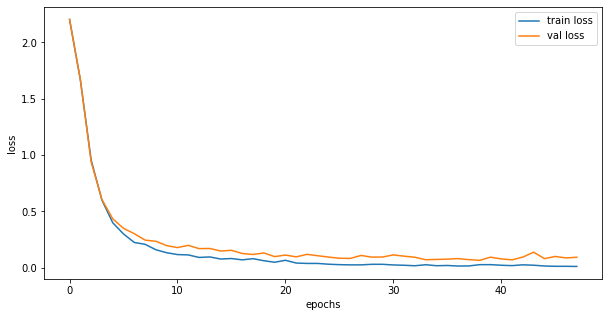

In [129]:
x = np.arange(epoch)
plt.plot(x, total_train_bid, label = "train loss")
plt.plot(x, total_val_bid, label = "val loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [130]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.103547
Accuracy: 0.969444


- Use pack_padded_sequence in the training of the model.

In [131]:
class BasicLSTM_packed(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False, dropout=0):
        super(BasicLSTM_packed, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_size = rnn_size
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.dropout = dropout

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        
        self.lstm = nn.LSTM(input_dim, self.rnn_size, self.num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.linear = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.rnn_size).to(DEVICE)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            c0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size).to(DEVICE)
            
        # Sort the input and lengths as the descending order
        lengths, perm_index = lengths.sort(0, descending=True)
        x = x[perm_index]
        

        packed_x = pack_padded_sequence(x, list(lengths.data), batch_first=True)
            
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(packed_x, (h0, c0))
        
        lstm_out = pad_packed_sequence(lstm_out, batch_first=True)[0]
        
        _, unperm_index = perm_index.sort(0)
        lstm_out = lstm_out[unperm_index]
        
        # Forward propagate Linear
        last_outputs = self.linear(self.last_timestep(lstm_out, lengths, self.bidirectional))
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Obtain the model's device ID
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1).to(DEVICE)
        return outputs.gather(1, idx).squeeze()

In [132]:
RNN_SIZE = 32
EPOCHS = 150

model = BasicLSTM_packed(num_mfcc, RNN_SIZE, 10, 2, dropout=0.3, bidirectional=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
n_epochs_stop = 10
min_val_loss = 1000
epochs_no_improve = 0

total_train_bid_packed = []
total_val_bid_packed = []

for epoch in range(EPOCHS):
    # Train the model for one epoch
    train_dataset(epoch, train_loader, model, loss_function, optimizer)
    
    # Evaluate the performance of the model, on both data sets
    train_loss, _ = eval_dataset(train_loader, model, loss_function)

    val_loss, _ = eval_dataset(val_loader, model, loss_function)
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(model, "./model_bid_packed")
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
            
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    print("Train: %f" %train_loss)
    print("Validation: %f" %val_loss)
    total_train_bid_packed.append(train_loss)
    total_val_bid_packed.append(val_loss)
    print()

Train: 2.199594
Validation: 2.202263

Train: 1.759289
Validation: 1.759699

Train: 1.222833
Validation: 1.237882

Train: 0.854517
Validation: 0.875846

Train: 0.645585
Validation: 0.672831

Train: 0.483290
Validation: 0.555055

Train: 0.364046
Validation: 0.419145

Train: 0.286972
Validation: 0.356035

Train: 0.243485
Validation: 0.298532

Train: 0.205069
Validation: 0.253855

Train: 0.171403
Validation: 0.239953

Train: 0.141161
Validation: 0.193273

Train: 0.117039
Validation: 0.147561

Train: 0.113630
Validation: 0.185737

Train: 0.091782
Validation: 0.171299

Train: 0.084824
Validation: 0.163468

Train: 0.082275
Validation: 0.159417

Train: 0.068152
Validation: 0.131704

Train: 0.061836
Validation: 0.146450

Train: 0.060233
Validation: 0.143656

Train: 0.049346
Validation: 0.159611

Train: 0.049234
Validation: 0.125979

Train: 0.038435
Validation: 0.125877

Train: 0.039878
Validation: 0.112961

Train: 0.047905
Validation: 0.103012

Train: 0.044201
Validation: 0.103644

Train: 0.041

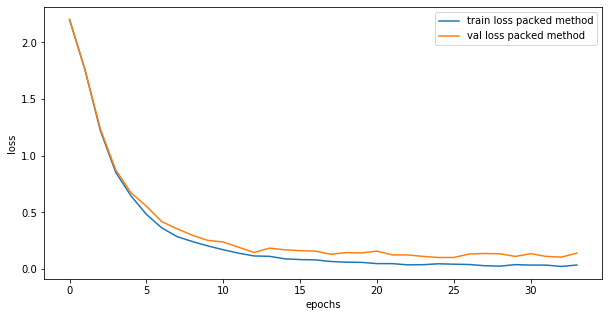

In [133]:
x = np.arange(epoch)
plt.plot(x, total_train_bid_packed, label = "train loss packed method")
plt.plot(x, total_val_bid_packed, label = "val loss packed method")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [134]:
val_loss, (y, y_pred) = eval_dataset(val_loader, model, loss_function)
print('Loss: %f' %val_loss)
y_conc = np.concatenate( y, axis=0 )
y_pred_conc = np.concatenate( y_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_conc, y_pred_conc))

Loss: 0.127965
Accuracy: 0.966667


Load the best model and perform final evaluation in test set.

In [136]:
best_model = torch.load('./model_bid_packed')
best_model.eval()

BasicLSTM_packed(
  (lstm): LSTM(6, 32, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

In [137]:
test_loss, (y_test, y_test_pred) = eval_dataset(test_loader, best_model, loss_function)
print('Loss: %f' %test_loss)
y_test_conc = np.concatenate( y_test, axis=0 )
y_test_pred_conc = np.concatenate( y_test_pred, axis=0 )
print('Accuracy: %f' %accuracy_score(y_test_conc, y_test_pred_conc))

Loss: 0.169713
Accuracy: 0.940000


In [138]:
best_cm = np.zeros((10, 10))
for i in range(test_size):
    best_cm[y_test_conc[i], y_test_pred_conc[i]] += 1

Normalized confusion matrix
[[0.95 0.   0.05 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.95 0.   0.05 0.   0.  ]
 [0.   0.   0.   0.05 0.   0.   0.85 0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.3  0.   0.7  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


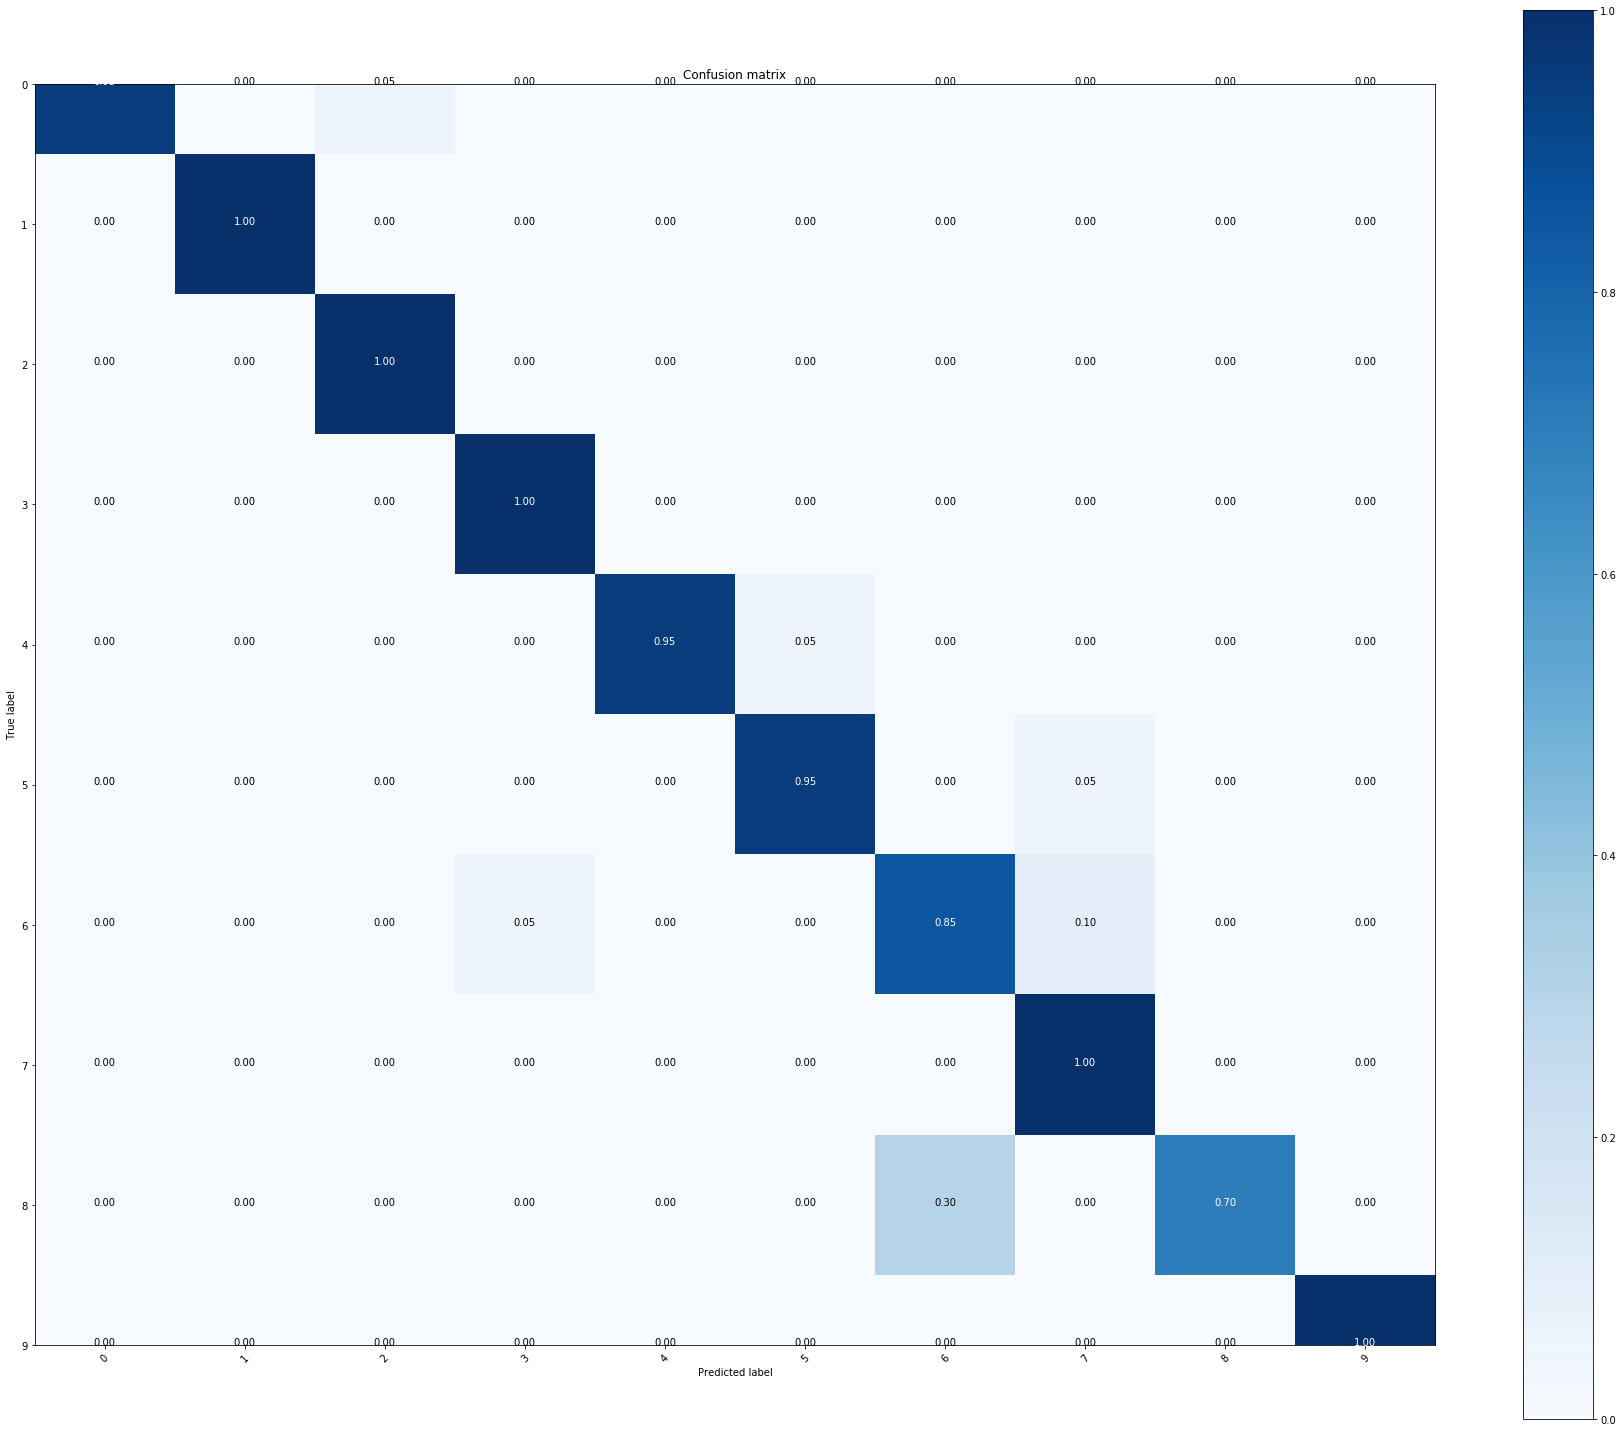

In [140]:
plt.rcParams['figure.figsize'] = [25, 20]
plot_confusion_matrix(best_cm, [i for i in range(10)], normalize=True)